In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Read the exported CSV file
dat = pd.read_csv("Data/ML_data.csv")

# Perform data preprocessing
dat["gender"] = dat["gender"].astype(int)
feature_cols = [col for col in dat.columns if "pre_" in col or "income_" in col or "age_" in col or "gender" in col]
dat[feature_cols] = (dat[feature_cols] - dat[feature_cols].mean()) / dat[feature_cols].std()

# Filter dat based on test != 1
train_data = dat[dat["test"] != 1]
test_data = dat[dat["test"] == 1]

n_features = len(feature_cols)
treatment_groups = train_data["tg"].nunique()

# Define the desired order of treatment groups
treatment_groups_order = ['3x1', '4x2', '6x2', '4x3', '5x3', '6x3', 'control']

# Convert tg to one-hot vector for training data
tg_one_hot = pd.get_dummies(train_data["tg"].astype(pd.CategoricalDtype(categories=treatment_groups_order, ordered=True)))

# Convert tg to one-hot vector for test data
tg_test_one_hot = pd.get_dummies(test_data["tg"].astype(pd.CategoricalDtype(categories=treatment_groups_order, ordered=True)))

# Define the neural network architecture
hidden_size = 128

class Net(nn.Module):
    def __init__(self, n_features, hidden_size):
        super(Net, self).__init__()
        self.hidden = nn.Linear(n_features, hidden_size)
        self.het = nn.Linear(hidden_size, treatment_groups)

    def forward(self, x, tg):
        x = self.hidden(x)
        x = torch.relu(x)
        x = self.het(x)
        x = x*tg
        x = torch.sum(x, dim=1, keepdim=True)
        return x

model = Net(n_features, hidden_size)

# Define the loss function and optimizer
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Convert the training data to tensors
X_train_tensor = torch.tensor(train_data[feature_cols].values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_data["num_ads"].values.reshape(-1, 1), dtype=torch.float32)
tg_train_tensor = torch.tensor(tg_one_hot.values, dtype=torch.float32)

# Create data loader for training
batch_size = 128
train_data = TensorDataset(X_train_tensor, y_train_tensor, tg_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Epoch: 1, Train Loss: 2939734.0764
Epoch: 2, Train Loss: 2182612.2935
Epoch: 3, Train Loss: 2166686.8913
Epoch: 4, Train Loss: 2160536.3871
Epoch: 5, Train Loss: 2158759.5724
Epoch: 6, Train Loss: 2155522.9725
Epoch: 7, Train Loss: 2154654.8982
Epoch: 8, Train Loss: 2151930.4322
Epoch: 9, Train Loss: 2152130.9274
Epoch: 10, Train Loss: 2150401.2287
Epoch: 11, Train Loss: 2150178.3633
Epoch: 12, Train Loss: 2149853.1905
Epoch: 13, Train Loss: 2148907.0046
Epoch: 14, Train Loss: 2147447.9589
Epoch: 15, Train Loss: 2147480.9791
Epoch: 16, Train Loss: 2146820.8584
Epoch: 17, Train Loss: 2147347.4672
Epoch: 18, Train Loss: 2146509.4044
Epoch: 19, Train Loss: 2146886.5603
Epoch: 20, Train Loss: 2146166.4636
Epoch: 21, Train Loss: 2145078.4572
Epoch: 22, Train Loss: 2145686.1821
Epoch: 23, Train Loss: 2144928.1514
Epoch: 24, Train Loss: 2144102.9212
Epoch: 25, Train Loss: 2145889.8549
Epoch: 26, Train Loss: 2144919.1952
Epoch: 27, Train Loss: 2143521.1562
Epoch: 28, Train Loss: 2143932.1702
E

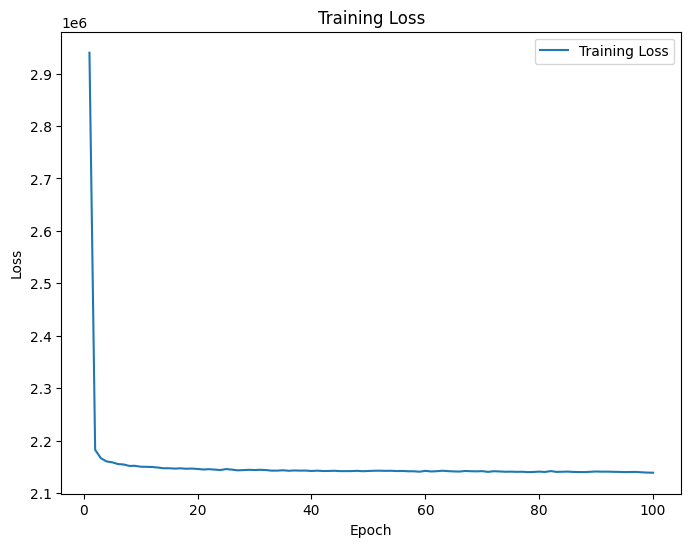

In [2]:

# Train the neural network
num_epochs = 100
train_losses = []
## fix the random seed
torch.manual_seed(0)
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_x, batch_y, batch_tg in train_loader:
        # Forward pass
        y_pred = model(batch_x, batch_tg)
        loss = loss_fun(y_pred, batch_y)
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Print the loss for monitoring
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}")

# Plot the training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()


In [3]:

# Predict the propensity of number of ads shown to each user in the test set
test_data_tensor = torch.tensor(test_data[feature_cols].values, dtype=torch.float32)

model.eval()
with torch.no_grad():
    hidden_layer = torch.relu(model.hidden(test_data_tensor))
    num_ads = model.het(hidden_layer).numpy()

## convert the predictions to a dataframe with column names as treatment groups and append "num_ads_pred_" to column names
num_ads_df = pd.DataFrame(num_ads, columns=["num_ads_pred_" + t for t in treatment_groups_order])
## append propensity scores to test_data and save 
test_data = pd.concat([test_data.reset_index(drop=True), num_ads_df], axis=1)
test_data.to_csv("Data_generate/ML_test_data_with_num_ads_prediction.csv", index=False)
